Equipo 2:

Álvaro Martín López

Daniel Pérez Martínez

# ANALIZADOR DE SENTIMIENTO (NLP con Python)

![title](resources/Images/0_Portada.jpg)

## INTRODUCCIÓN

En este informe se verá todo el proceso necesario para crear un analizador de sentimiento en Python. Este proceso comprende desde la búsqueda y exploración del conjunto de datos hasta la visualización del resultado final.

En concreto, primero veremos alternativas para obtener datos de entrenamiento para nuestro modelo y cómo debemos ajustarlos para un correcto funcionamiento del mismo.

Posteriormente, veremos el pre-procesamiento necesario en estos datos de cara al NLP, para lo que utilizaremos funcionalidades de las librerías [INSERTAR AQUÍ LO QUE VAYA A USAR]

Una vez tengamos el conjunto de datos listo, procederemos a crear nuestro modelo y a entrenarlo con los datos obtenidos.

Por último, realizaremos una predicción para comprobar la precisión de nuestro modelo.

También se incluye un apartado con conclusiones y consideraciones varias

## EXPLORACIÓN DE DATOS

Nuestro modelo clasificador utiliza el paradigma del aprendizaje supervisado. Esto significa que tenemos que aportarle como entrada un conjunto de datos etiquetados. 

En nuestro caso, este conjunto de datos será una colección de frases con su correspondiente etiqueta indicando el sentimiento de la misma.

Para ello, nos apoyaremos en kaggle.com. Kaggle, una subsidiaria de Google LLC, es una comunidad en línea de científicos de datos y profesionales del aprendizaje de máquinas. Kaggle permite a los usuarios encontrar y publicar conjuntos de datos, explorar y construir modelos en un entorno de ciencia de datos basado en la web, trabajar con otros científicos de datos e ingenieros de aprendizaje de máquinas, y participar en competiciones para resolver los desafíos de la ciencia de datos. 

Así pues, buscaremos algún conjunto de datos que nos valga, como https://www.kaggle.com/c/spanish-arilines-tweets-sentiment-analysis/data

Este conjunto consiste en diversos tweets en español acerca de las experiencias de viajeros con distintas compañias. Como podemos ver en la preview de Kaggle, contamos con varias versiones que añaden campos extra, como si los tweets son respuestas a otros, las localizaciones de los mismo... En el caso que nos ocupa solo queremos el texto y la etiqueta, por lo que descargaremos la versión simple:

![title](resources/Images/1_Kaggle_Preview.png)


En la imagen superior podemos ver los porcentajes de tweets de cada tipo. Como se puede observar, las negativas son  más frecuentes que las neutrales o positivas, algo que puede afectar al modelo. También podemos ver que no hay valores nulos o que falten, algo que no sería deseable tampoco. Por último, vemos que aparte de "text" y "airline_sentiment", los campos que nos sirven para el caso que nos ocupa, también contamos con otros campos extra de los que nos desharemos a continuación.

Sin embargo, no siempre se dispone de las herramientas de kaggle para poder ver estos datos pues, en muchas ocasiones, el conjunto de datos de entrada lo habremos generado nosotros mismos. Veamos cómo explorar estos datos a mano ayudandonos de la librería *pandas*:

In [1]:
import pandas as pd

data = pd.read_csv('resources/tweets_public.csv')
data.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,neutral,False,0,0,Trabajar en #Ryanair como #TMA: https://t.co/r...,NaN,Fri Nov 03 12:05:12 +0000 2017,926419989107798016,NaN,Madrid
1,neutral,True,0,0,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,NaN,Sun Nov 26 18:40:28 +0000 2017,934854385577943041,NaN,Mexico City
2,negative,False,0,0,Sabiais que @Iberia te trata muy bien en santi...,NaN,Mon Dec 25 15:40:45 +0000 2017,945318406441635840,NaN,Madrid
3,negative,False,0,0,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,NaN,Mon Nov 06 14:18:35 +0000 2017,927540721296568320,NaN,Pacific Time (US & Canada)
4,positive,True,0,0,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,NaN,Mon Jan 01 23:00:57 +0000 2018,947965901332197376,NaN,Buenos Aires


Primero nos desharemos de las columnas que no nos interesan para nuestro caso y cambiaremos el nombre de una a algo más accesible

In [2]:
data = data[['airline_sentiment','text']]
data.rename(columns = {'airline_sentiment' : 'sentiment'}, inplace = True)
data.head()

,sentiment,text
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...
2,negative,Sabiais que @Iberia te trata muy bien en santi...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...
4,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...


Veamos ahora si tenemos algún valor nulo o que no encaje aunque, como ya sabíamos, no los hay:

In [3]:
data.isnull()[data.isnull().eq(True).any(1)]

,sentiment,text


Ahora que tenemos el conjunto con una preparación inicial, utilizaremos herramientas que nos ofrece la librería *pandas* para visualizar gráficamente los datos:

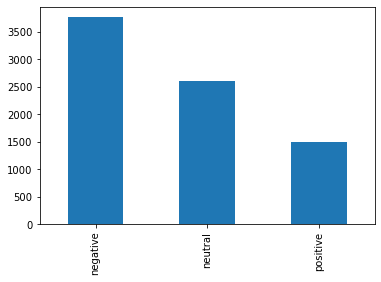

In [4]:
pd.value_counts(data['sentiment']).plot(kind = 'bar')

Como la diferencia no es sumamente notoria y este informe pretende enseñar los pasos más que resultados admirables, no vamos a editar más el conjunto de datos aunque, de ser necesario, se eliminarían frases aleatorias de los tipos que correspondan para tener un conjunto más igualado. 

Es importante recalcar que esto último no siempre es necesario, pues las frecuencias de aparición de cada tipo a veces son unas mayores que otras de forma natural

__NOTA__: Es necesario remarcar que la precisión del modelo se verá en su mayor parte afectada por la calidad del conjunto de datos de entrada. Sin embargo, los datasets de sentimiento públicos para textos en español son bastante escasos y de una calidad media. Se avisa que la precisión final del modelo no será muy alta debido a esto. Más información en el apartado de consideraciones

## PRE-PRECESAMIENTO DE LOS DATOS

Antes de introducir estos datos a nuestro modelo, debemos aplicarles un preprocesamiento. Estamos trabajando con lenguaje natural, el cual es vasto y variante, por lo que hay que tomar una serie de medidas para normalizar los datos. 

En nuestro caso, recorreremos nuestro conjunto transformando las frases a minúscula y cambiando las letras con tilde por las mismas sin tilde, ya que al coger los datos de tweets, debemos tener en cuenta que no todo el mundo escribe correctamente. Dejaremos solo las letras (esto es, quitar emojis, links, hashtags, puntuación..) de forma que solo queden palabras y, una vez hecho, las lematizaremos, es decir, obtendremos el lexema o raíz. Esto resulta muy útil para que tokens que la máquina podría considerar distintos a priori ( _corrió, corrimos_ ) sean considerados correctamente como un mismo token ( _correr_ ).

Por último, eliminaremos las llamadas _stopwords_ , que vienen siendo palabras que suelen ser frecuentes pero no aportan nada de significado real, como pueden ser preposiciones, conjunciones...

Empecemos entonces con el paso a minúsculas y la sustitución de tildes:

In [5]:
def to_lower_and_remove_accents(sentence):
    replacements = {
        "á" : "a",
        "é" : "e",
        "í" : "i",
        "ó" : "o",
        "ú" : "u",
    }
    sentence = sentence.lower()
    for i,j in replacements.items():
        sentence = sentence.replace (i,j)
    return sentence

    
data['tokens'] = data['text'].apply(to_lower_and_remove_accents)
data.head(4)

,sentiment,text,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,trabajar en #ryanair como #tma: https://t.co/r...
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,@iberia @fionaferrer cuando gusten en cancun s...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,sabiais que @iberia te trata muy bien en santi...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,nunca nunca nunca pidais el cafe de ryanair.\n...


A continuación, definiremos una función que eliminará los hashtags, menciones y links. Para ello nos ayudaremos del módulo de expresiones regulares _re_

In [6]:
import re
def only_words(sentence):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split())

In [7]:
test= "Esto es una prueba hecha por @alvaro y @dani para #TIE y aquí un link falso: https://unaweb.com/tienda"
print(only_words(test))

Esto es una prueba hecha por y para y aqu un link falso


In [8]:
data['tokens'] = data['tokens'].apply(only_words)
data.head(4)

,sentiment,text,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,trabajar en como
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,cuando gusten en cancun se viaja y disfruta de...
2,negative,Sabiais que @Iberia te trata muy bien en santi...,sabiais que te trata muy bien en santiago de c...
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,nunca nunca nunca pidais el cafe de ryanair bu...


__NOTA__ : Según la intención del analizador, puede que no nos interese eliminar las menciones. Por ejemplo, si lo que queremos es obtener la opinión de distintas compañías de vuelo utilizando este dataset, nos interesa eliminar únicamente el símbolo "@" pero dejar el nombre "iberia", "ryanair"... Puesto que únicamente nos interesa mostrar cómo crear un modelo genérico, hemos optado por eliminar todas las menciones y hashtags

Como podemos observar, gracias a la expresión regular anterior hemos eliminado también los signos de puntuación. Las expresiones regulares resultan muy útiles a la hora de preprocesar texto y suponen una herramienta muy potente si se es capaz de adecuar a nuestras necesidades

A continuación procederemos a lematizar nuestro texto, cambiar formas verbales a infinitivo, sustantivos y adjetivos a singular, etc. Para ello nos apoyaremos en la herramienta _spaCy_ . Esta herramienta es muy potente cuando se trata de procesar lenguaje natural. Es capaz incluso de realizar análisis semántico cuando el texto está correctamente escrito y además con una precisión asombrosa. Sin embargo, nuestros datos proceden de _tweets_ así que únicamente utilizaremos su lematizador.

__NOTA__ : Una vez más, encontramos dificultades dado el idioma de nuestro texto. Sin embargo, _spaCy_ ofrece también un módulo en español, aunque no tan bueno como el inglés dada la complejidad de nuestro lenguaje. Este módulo puede ser descargado con: _(python -m spacy download es_core_news_md)_

In [9]:
import spacy
nlp = spacy.load('es_core_news_md')

def lematize(sentence):
    doc = nlp(sentence)
    result = ""
    for token in doc:
        result += token.lemma_ + " "
    return result

Aunque la lematización es muy útil en el NLP, es un proceso costoso y lento, por lo que debe considerarse su uso. 

In [10]:
test = "Este era un test para comprobar qué tal funciona SpacY en español con algunos plurales y algunos verbos como corrieron y volaron"
print(lematize(test))

Este ser uno test parir comprobar qué tal funcionar SpacY en español con alguno plural y alguno verbo comer correr y volar 


Además, como vemos, hay ciertas palabras que no lematiza correctamente. Por ejemplo, "para" lo interpreta como si proviniese del verbo "parir" y "como" del verbo "comer". Por esta razón, aplicaremos antes el filtro de _stopwords_ que la lematización.

Para la eliminación de _stopwords_ usaremos de nuevo la librería _spaCy_ , que cuenta con una lista de _stopwords_ también en español que nos permitirá crear un filtro. 

In [11]:
from spacy.lang.es.stop_words import STOP_WORDS
def remove_stop_words(sentence):
    result = list()
    if sentence != None:
        sentence = list(sentence.split(" "))
        result = list(
        filter(lambda l: (l not in STOP_WORDS and len(l) > 2), sentence))
    return result

In [12]:
test = "esto es un test para ver el funcionamiento de la funcion que elimina stopwords"
print(remove_stop_words(test))

['test', 'funcionamiento', 'funcion', 'elimina', 'stopwords']


Así pues, eliminamos las _stopwords_ de nuestro conjunto de datos y, posteriormente, aplicamos la lematización, aunque debemos retocar la función para que funcione con listas en lugar de cadenas:

In [13]:
data['tokens'] = data['tokens'].apply(remove_stop_words)
data.head(4)

,sentiment,text,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,[]
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,"[gusten, cancun, viaja, disfruta]"
2,negative,Sabiais que @Iberia te trata muy bien en santi...,"[sabiais, santiago, chile, cambia, asiento, ma..."
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,"[pidais, cafe, ryanair, vendan, bordo]"


In [14]:
def lematize(sentence_list):
    result = []
    if len(sentence_list) > 0:
        for word in sentence_list:
            doc = nlp(word)
            for token in doc:
                result.append(token.lemma_)
    return result

In [15]:
data['tokens'] = data['tokens'].apply(lematize)
data.head(4)

,sentiment,text,tokens
0,neutral,Trabajar en #Ryanair como #TMA: https://t.co/r...,[]
1,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,"[gustar, cancun, viajar, disfrutar]"
2,negative,Sabiais que @Iberia te trata muy bien en santi...,"[sabiais, santiago, chile, cambiar, asentir, m..."
3,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,"[pidais, cafe, ryanair, vender, bordar]"


Por último, eliminaremos aquellas oraciones que hayan quedado vacías tras el preprocesamiento y, una vez hecho esto, podremos comenzar a crear nuestro modelo clasificador

In [16]:
data = data[data['tokens'].map(lambda d: len(d)) > 0]
data = data.reset_index()
data = data.drop(columns={'index'})
data.head(4)

,sentiment,text,tokens
0,neutral,@Iberia @FIONAFERRER Cuando gusten en Cancún s...,"[gustar, cancun, viajar, disfrutar]"
1,negative,Sabiais que @Iberia te trata muy bien en santi...,"[sabiais, santiago, chile, cambiar, asentir, m..."
2,negative,NUNCA NUNCA NUNCA pidáis el café de Ryanair.\n...,"[pidais, cafe, ryanair, vender, bordar]"
3,positive,@cris_tortu @dakar @Iberia @Mitsubishi_ES @BFG...,"[tortu, exito]"


__NOTA__: Obviamente las funciones anteriores se pueden agrupar dentro de una mayor que realice todo el preprocesamiento necesario a cada oración, pero de esta forma es más claro para explicar cada parte. Antes de continuar con la creación y entrenamiento del modelo debemos recordar que el preprocesamiento es una parte clave en el NLP y que, si bien cuanto más completo sea mejores resultados obtendremos, hay que adecuarlo a nuestras necesidades, pues puede suponer un coste en tiempo de computación bastante elevado.

## CREACIÓN Y ENTRENAMIENTO DEL MODELO

## PREDICCIÓN

## VISUALIZACIÓN Y CONCLUSION FINAL

## Referencias

Kaggle - https://www.kaggle.com/

Spanish Airlines Tweets Sentiment Analyis - https://www.kaggle.com/c/spanish-arilines-tweets-sentiment-analysis/data

Pandas - https://pandas.pydata.org/

Regex - https://docs.python.org/3/library/re.html

SpaCy - https://spacy.io/

SpaCY español - https://spacy.io/models/es